<a href="https://colab.research.google.com/github/notrandomath/Recipe-Generator-AI/blob/main/Food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Based on: [shakespeare generator](https://github.com/trekhleb/machine-learning-experiments/blob/master/experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.ipynb)

# Import Dependencies

In [ ]:
from google.colab import drive
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import ast
import shutil

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)

Python version: 3.10.12
Tensorflow version: 2.15.0


# Import Dataset


change project folder location to google drive (source: https://robertbrucecarter.com/writing/2020/06/setting-your-working-directory-to-google-drive-in-a-colab-notebook/)

In [ ]:
# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/MyDrive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/Food/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

create_and_set_working_directory(project_folder)

limit the data to first 1024 rows so that training takes a reasonable time

In [ ]:
df=pd.read_csv('food_recipes/RAW_recipes.csv')
df = df.head(1024)
print(df)

                                            name      id  minutes  \
0     arriba   baked winter squash mexican style  137739       55   
1               a bit different  breakfast pizza   31490       30   
2                      all in the kitchen  chili  112140      130   
3                             alouette  potatoes   59389       45   
4             amish  tomato ketchup  for canning   44061      190   
...                                          ...     ...      ...   
1019                         1949  spanish  rice  394049       60   
1020                    1949 country style steak  221166       20   
1021                             1950 s brownies  254267       42   
1022                    1950 s hamburger goulash  109232       50   
1023                             1950 s meatloaf  275691       85   

      contributor_id   submitted  \
0              47892  2005-09-16   
1              26278  2002-06-17   
2             196586  2005-02-25   
3              68585  2003-

# Analyze Dataset

convert each entry in a row from the format "[step 1, step 2, step 3]" to "step 1\nstep 2\nstep 3" then combine all rows to one giant string and make the vocab from the string

In [ ]:
def convert_to_list(string_representation):
    lst = ast.literal_eval(string_representation)
    return "\n".join(lst) + '\n'
df['steps'] = df['steps'].apply(lambda x: convert_to_numbered_list(x))

In [ ]:
all_steps_text = ''.join(df['steps'])
# gets length of all the steps in all recipes
print(len(all_steps_text))
# prints first steps
print(all_steps_text[:250])
# prints the unique characters in the file
vocab = sorted(set(all_steps_text.replace("\n", " \n ").split(sep=" ")))
print(f'{len(vocab)} unique words')
print(f'vocab: {vocab}')

529981
make a choice and proceed with recipe
depending on size of squash , cut into half or fourths
remove seeds
for spicy squash , drizzle olive oil or melted butter over each cut squash piece
season with mexican seasoning mix ii
for sweet squash , drizzle
4549 unique words
vocab: ['', '\n', '!', '"', '"al', '"basic"', '"basket"', '"batter"', '"beginner"', '"bun"', '"buttermilk"', '"caramalized"', '"cheese"', '"chicken"', '"chill"', '"cinnamon', '"combine', '"cooking"', '"crusty"', '"dances"', '"dress', '"dry"', '"dust"', '"exactly', '"eyeballing"', '"float"', '"flower', '"flower"', '"fudgy"', '"give"', '"high"', '"hold"in', '"ice', '"jiggly"', '"ketchup"', '"lettuce"', '"light"', '"little', '"low"', '"mash"', '"mc', '"milk"', '"mustard"', '"naked"', '"noodles"', '"one-dish"', '"paint"', '"petals"', '"pounding"', '"rest', '"rough"', '"sauce', '"sauce"', '"scoop"', '"shirataki"', '"shriveled"', '"sink"', '"slushy"', '"soupy"', '"special', '"squeaking"', '"start"', '"the', '"thicken"', 

# Process Dataset

## Vectorize the Text
Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [ ]:
# Map characters to their indices in vocabulary.
word2index = {word: index for index, word in enumerate(vocab)}

print('{')
for word, _ in zip(word2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(word), word2index[word]))
print('  ...\n}')

# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

# Convert chars in text to indices (we make a new column for the indices).
df['steps_int'] = df['steps'].apply(lambda x: [word2index[word] for word in x.replace("\n", " \n ").split(sep=" ")])
text_as_int = df['steps_int'].explode().reset_index(drop=True).tolist()

print(f'text_as_int length: {len(text_as_int)}')
print(f'({all_steps_text[:15]})->({text_as_int[:15]})')

{
  ''  :   0,
  '\n':   1,
  '!' :   2,
  '"' :   3,
  '"al':   4,
  '"basic"':   5,
  '"basket"':   6,
  '"batter"':   7,
  '"beginner"':   8,
  '"bun"':   9,
  '"buttermilk"':  10,
  '"caramalized"':  11,
  '"cheese"':  12,
  '"chicken"':  13,
  '"chill"':  14,
  '"cinnamon':  15,
  '"combine':  16,
  '"cooking"':  17,
  '"crusty"':  18,
  '"dances"':  19,
  ...
}
['' '\n' '!' ... '~' '~30' '~tasty~']
text_as_int length: 112578
(make a choice a)->([2473, 440, 1044, 546, 3176, 4466, 3278, 1, 1391, 2817, 3647, 2793, 3819, 90, 1327])


# Create training sequences

In [ ]:
# # Convert the pandas DataFrame to a tf.data.Dataset
sub_text_as_int = df['steps_int'].explode().reset_index(drop=True).tolist()

dataset = tf.data.Dataset.from_tensor_slices(sub_text_as_int)

for char in dataset.take(5):
    print(index2char[char.numpy()])

# make sequences
sequence_length = 100
dataset = dataset.batch(sequence_length+1, drop_remainder=True)

for item in dataset.take(5):
  print(' '.join(index2char[item.numpy()]))

make
a
choice
and
proceed
make a choice and proceed with recipe 
 depending on size of squash , cut into half or fourths 
 remove seeds 
 for spicy squash , drizzle olive oil or melted butter over each cut squash piece 
 season with mexican seasoning mix ii 
 for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece 
 season with sweet mexican spice mix 
 bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin 
 be careful not
to burn the squash especially if you opt to use sugar or butter 
 if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking 
 if desired , season with salt 
  preheat oven to 425 degrees f 
 press dough into the bottom and sides of a 12 inch pizza pan 
 bake for 5 minutes until set but not browned 
 cut sausage into small pieces 
 whisk eggs and milk in a bowl until frothy 
 spoon sausage over baked crust and

Makes the target the next word so the RNN predicts the next word

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1] # input_text = chunk[:, :-1]
    target_text = chunk[1:] # target_text = chunk[:, 1:]
    return input_text, target_text

    # return input_text, target_text

dataset = dataset.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

for input_example, target_example in dataset.take(1):
    print(f'Input sequence size: {len(input_example.numpy())}')
    print(f'Input sequence size: {len(target_example.numpy())}')
    print()
    print('Input: ' + ''.join(str(index2char[i]) for i in input_example.numpy()))
    print('Target: ' + ''.join(str(index2char[i]) for i in target_example.numpy()))

for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print(f'  input: {input_idx} ({index2char[input_idx]})')
    print(f'  expected output: {target_idx} ({index2char[target_idx]})')

dataset size: 1114
Input sequence size: 100
Input sequence size: 100

Input: makeachoiceandproceedwithrecipe
dependingonsizeofsquash,cutintohalforfourths
removeseeds
forspicysquash,drizzleoliveoilormeltedbutterovereachcutsquashpiece
seasonwithmexicanseasoningmixii
forsweetsquash,drizzlemeltedhoney,butter,gratedpiloncilloovereachcutsquashpiece
seasonwithsweetmexicanspicemix
bakeat350degrees,againdependingonsize,for40minutesuptoanhour,untilaforkcaneasilypiercetheskin
becareful
Target: achoiceandproceedwithrecipe
dependingonsizeofsquash,cutintohalforfourths
removeseeds
forspicysquash,drizzleoliveoilormeltedbutterovereachcutsquashpiece
seasonwithmexicanseasoningmixii
forsweetsquash,drizzlemeltedhoney,butter,gratedpiloncilloovereachcutsquashpiece
seasonwithsweetmexicanspicemix
bakeat350degrees,againdependingonsize,for40minutesuptoanhour,untilaforkcaneasilypiercetheskin
becarefulnot
Step  0
  input: 2473 (make)
  expected output: 440 (a)
Step  1
  input: 440 (a)
  expected output: 1044 (choi

# Build the Model

Makes the RNN (I'm using an LSTM here for the next word predictor)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           1164544   
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 4549)          4662725   
                                                                 
Total params: 11074245 (42.24 MB)
Trainable params: 11074245 (42.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


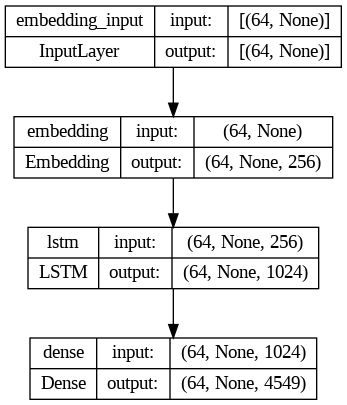

In [ ]:
# Define the batch size
batch_size = 64

# Batch the dataset
dataset = dataset.batch(batch_size, drop_remainder=True)

# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

# *Test* the Model

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 4549) # (batch_size, sequence_length, vocab_size)


In [ ]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-0.0015065   0.00160686  0.00016674 ... -0.00129838  0.00128885
  0.00074766], shape=(4549,), dtype=float32)


# Train the model

In [ ]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

Prediction shape:  (64, 100, 4549)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       8.422959


# Configure Checkpoints

In [ ]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
# uncomment below to remove any previous checkpoints:
# if os.path.exists(checkpoint_dir):
        # shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Execute the training

In [ ]:
for input_data, labels in dataset.take(1):
    print("Input data shape:", input_data.shape)
    print("Labels shape:", labels.shape)

EPOCHS=40

history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Input data shape: (64, 100)
Labels shape: (64, 100)
Epoch 1/40
17/17 [==============================] - 194s 11s/step - loss: 6.5996
Epoch 2/40
17/17 [==============================] - 192s 11s/step - loss: 5.9062
Epoch 3/40
17/17 [==============================] - 196s 12s/step - loss: 5.8289
Epoch 4/40
17/17 [==============================] - 197s 12s/step - loss: 5.7237
Epoch 5/40
17/17 [==============================] - 204s 12s/step - loss: 5.5565
Epoch 6/40
17/17 [==============================] - 203s 12s/step - loss: 5.3808
Epoch 7/40
17/17 [==============================] - 194s 11s/step - loss: 5.2182
Epoch 8/40
17/17 [==============================] - 193s 11s/step - loss: 5.0708
Epoch 9/40
17/17 [==============================] - 199s 12s/step - loss: 4.9409
Epoch 10/40
17/17 [==============================] - 191s 11s/step - loss: 4.8213
Epoch 11/40
17/17 [==============================] - 190s 11s/step - loss: 4.7073
Epoch 12/40
17/17 [==============================] - 19

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()
render_training_history(history)

NameError: ignored

# Generate text

In [ ]:
checkpoint_dir = 'tmp/checkpoints'

tf.train.latest_checkpoint(checkpoint_dir)

simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            1164544   
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 4549)           4662725   
                                                                 
Total params: 11074245 (42.24 MB)
Trainable params: 11074245 (42.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_index = [word2index[word] for word in start_string.split()]
    input_indices = tf.expand_dims(input_index, 0)

    # Index to keep track of step number
    index = 1
    # Empty string to store our results.
    text_generated = []

    text_generated.append(f'{index}. {start_string}')

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        if "\n" == index2char[predicted_id]:
          text_generated[-1] += f'\n{index}.'
          index += 1
        elif " " == index2char[predicted_id] or "" == index2char[predicted_id]:
          pass
        elif "," == index2char[predicted_id] or "!" == index2char[predicted_id]:
          text_generated[-1] += index2char[predicted_id]
        else:
          text_generated.append(index2char[predicted_id].strip())


    return (' '.join(text_generated))

# Generate the text with default temperature (1.0).
print(generate_text(model, start_string="start by"))

1. start by notable space petals self over gelatin
1. cover, cook over medium-high heat
2. add flour, beginning to a couple minutes
3. reduce heat to low
4. simmer 10 minutes, stirring once and adjusting meat batter
5. stir in microwave blender, add tuna whites to taste
6. s to medium
7. cook for 12- 15 min 25 minutes and allow to ladle to cool!
8. spray and wire in roasting pan or potato sided coriander, or until your cheese is lightly browned
9. with flour crust, cooked the loaf pan and mix together
10. preheat oven to 350 and spray
11. mix together the dry ingredients to make a smooth smaller
12. grease
13. reduce this, fry 2-3 seconds or until browned through
14. you can bake at 350 f
15. cut each or tube pans in pizza pan
16. place for one square container, line 4 claws
17. place a cone brush into a tight offset potatoes, cut out on floured surface or spray and wrap with cooking
18. ps
19. preheat oven to 325 degrees covered with cooking sprayed
20. prepare an 8-inch warm water, w

Saves the model

In [ ]:
model_name = 'text_generation_shakespeare_rnn.h5'
model.save(model_name, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
